# SEGMENTATION MODEL

### Prepare Library, Parameters, and Dependencies

In [14]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
from tqdm import tqdm

%matplotlib inline

In [15]:
# UNCOMMENT THIS IF YOU USE GOOGLE COLAB

# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  0


In [17]:
DATASET_DIR = "datasets/classification_datasets/cataract_dataset_mixed_blended"
TEST_PREDICT_DIR = "datasets/test_predict"

BATCH_SIZE = 16
VAL_RATIO = 0.3
SHUFFLE_BUFFER_SIZE = 1100

IMG_HEIGHT = 128
IMG_WIDTH = 128

SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

### Load & Split Dataset

In [18]:
# Make Train Dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=VAL_RATIO,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE,
)

# Make Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=VAL_RATIO,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE,
)

# Make Test Dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 3)
val_ds = val_ds.skip(val_batches // 3)

# Print Dataset Information
print(f'Number of training batches: {len(np.concatenate([i for x, i in train_ds]))}')
print(f'Number of validation batches: {len(np.concatenate([i for x, i in val_ds]))}')
print(f'Number of test batches: {len(np.concatenate([i for x, i in test_ds]))}')

Found 1164 files belonging to 3 classes.
Using 815 files for training.
Found 1164 files belonging to 3 classes.
Using 349 files for validation.
Number of training batches: 815
Number of validation batches: 237
Number of test batches: 112


['mild', 'normal', 'severe']


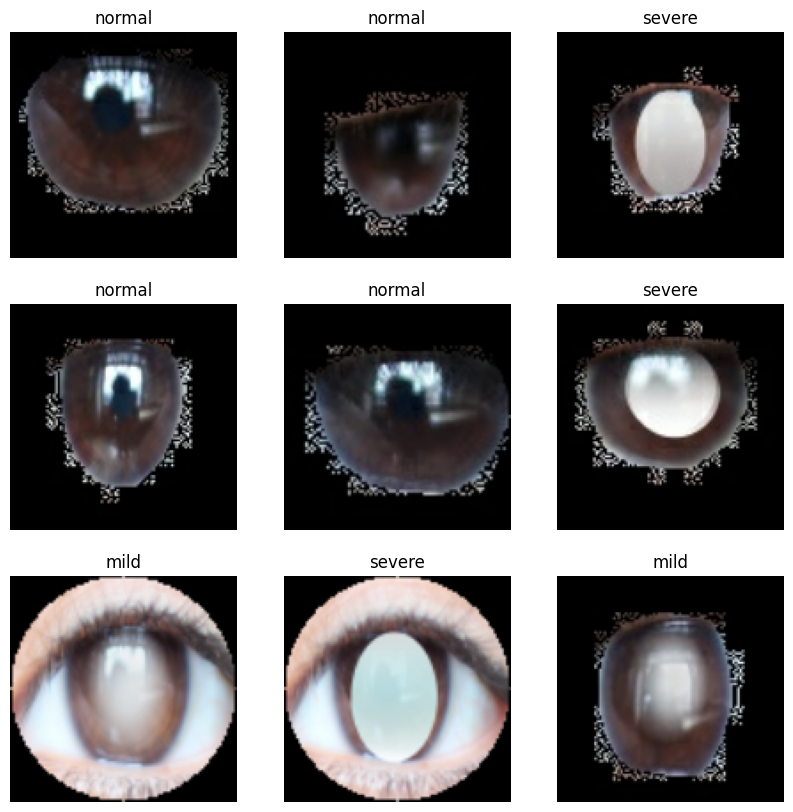

In [19]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Data Augmentation & Preparation

In [20]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip(mode='horizontal'),
    keras.layers.RandomRotation(factor=0.4),
    keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
])

In [21]:
train_ds = train_ds.cache().shuffle(SHUFFLE_BUFFER_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Callbacks

In [22]:
class my_callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy')>0.85:
            print("\nReached chosen accuracy so cancelling training!")
            self.model.stop_training = True

### Model Architecture #1 (CNN Vanilla)

In [29]:
model = tf.keras.Sequential([
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    data_augmentation,
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(class_names))
])

In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)       

### Train Model #1

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    # callbacks=[myCallback()]
)

### Evaluate Model With Test Dataset

In [ ]:
acc = model.history['accuracy']
val_acc = model.history['val_accuracy']

loss = model.history['loss']
val_loss = model.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('1st Model Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('1st Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)

In [ ]:
y_true = np.concatenate([i for x, i in test_ds])
y_pred = np.argmax(model.predict(test_ds), axis=-1)

conf_mat = confusion_matrix(y_true, y_pred)

In [ ]:
def show_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=15)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [ ]:
show_confusion_matrix(conf_mat, class_names)

### Test With Cataract Dataset

In [ ]:
predict_model = keras.Sequential([
    model,
    keras.layers.Softmax()
])

In [ ]:
for filename in os.listdir(TEST_DIR):
    img = keras.preprocessing.image.load_img(TEST_DIR + filename, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = predict_model.predict(img_array)
    
    score = tf.nn.softmax(predictions[0])
    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
    print(predictions)